In [1]:
### Let's use TD3 + HER
### I tested it using just TD3 and the actor can't learn anything.
### Same for all the robotic environments and BipedalWalker

In [2]:
import warnings
warnings.simplefilter('ignore')
import tensorflow as tf

In [3]:
print("Is GPU available?", tf.test.is_gpu_available())
print("TF version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available? True
TF version: 2.3.1
Keras version: 2.4.0


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE

from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import random
import gym

In [5]:
class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.f1 = tf.keras.layers.Dense(512, activation='relu')
        self.f2 = tf.keras.layers.Dense(512, activation='relu')
        self.v =  tf.keras.layers.Dense(1, activation=None)

    def call(self, state, action, goal):
        x = self.f1(tf.concat([state, action, goal], axis=1))
        x = self.f2(x)
        x = self.v(x)
        return x


class Actor(tf.keras.Model):
    def __init__(self, no_action):
        super(Actor, self).__init__()    
        self.f1 = tf.keras.layers.Dense(512, activation='relu')
        self.f2 = tf.keras.layers.Dense(512, activation='relu')
        self.mu =  tf.keras.layers.Dense(no_action, activation='tanh')

    def call(self, state, goal):
        x = self.f1(tf.concat([state, goal], axis=1))
        x = self.f2(x)
        x = self.mu(x)  
        return x

In [6]:
class Agent():
    def __init__(self, n_actions, min_action, max_action):
        self.actor_main = Actor(n_actions)
        self.actor_target = Actor(n_actions)
        self.critic_main = Critic()
        self.critic_main2 = Critic()
        self.critic_target = Critic()
        self.critic_target2 = Critic()
        self.batch_size = 64
        self.n_actions = n_actions
        self.a_opt = tf.keras.optimizers.Adam(0.001)
        self.c_opt1 = tf.keras.optimizers.Adam(0.002)
        self.c_opt2 = tf.keras.optimizers.Adam(0.002)
        self.memory = deque(maxlen=100000)
        self.trainstep = 0
        self.gamma = 0.99
        self.min_action = min_action
        self.max_action = max_action
        self.actor_update_steps = 2
        self.warmup = 200
        self.actor_target.compile(optimizer=self.a_opt)
        self.critic_target.compile(optimizer=self.c_opt1)
        self.critic_target2.compile(optimizer=self.c_opt2)
        self.tau = 0.005


    def act(self, state, goal, evaluate=False):
        if self.trainstep > self.warmup:
            evaluate = True
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        goal = tf.convert_to_tensor([goal], dtype=tf.float32)
        actions = self.actor_main(state, goal)
        if not evaluate:
            actions += tf.random.normal(shape=[self.n_actions], mean=0.0, stddev=0.1)

        actions = self.max_action * (tf.clip_by_value(actions, self.min_action, self.max_action))
        
        return actions[0]
    
    def store(self, state, action, reward, n_state, done, desired_goal):
        pack = [state, action, reward, n_state, 1 - int(done), desired_goal]
        self.memory.append(pack)
    
    def take_data(self, batch_size):
        pack = random.sample(self.memory, batch_size)
        states = []
        actions = []
        rewards = []
        n_states = []
        dones = []
        goals = [] # Desired goal
        for i in range(batch_size):
            states.append(pack[i][0])
            actions.append(pack[i][1])
            rewards.append(pack[i][2])
            n_states.append(pack[i][3])
            dones.append(pack[i][4])
            goals.append(pack[i][5])
        return states, actions, rewards, n_states, dones, goals

    def update_target(self, tau=None):

        if tau is None:
            tau = self.tau

        weights1 = []
        targets1 = self.actor_target.weights
        for i, weight in enumerate(self.actor_main.weights):
            weights1.append(weight * tau + targets1[i]*(1-tau))
        self.actor_target.set_weights(weights1)

        weights2 = []
        targets2 = self.critic_target.weights
        for i, weight in enumerate(self.critic_main.weights):
            weights2.append(weight * tau + targets2[i]*(1-tau))
        self.critic_target.set_weights(weights2)


        weights3 = []
        targets3 = self.critic_target2.weights
        for i, weight in enumerate(self.critic_main2.weights):
            weights3.append(weight * tau + targets3[i]*(1-tau))
        self.critic_target2.set_weights(weights3)
    
    def upgrade(self):
        if len(self.memory) < self.batch_size:
            return 

        states, actions, rewards, n_states, dones, goals = self.take_data(self.batch_size)

        states = tf.convert_to_tensor(states, dtype= tf.float32)
        n_states = tf.convert_to_tensor(n_states, dtype= tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype= tf.float32)
        actions = tf.convert_to_tensor(actions, dtype= tf.float32)
        goals = tf.convert_to_tensor(goals, dtype=tf.float32)

        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:

            target_actions = self.actor_target(n_states, goals)
            target_actions += tf.clip_by_value(tf.random.normal(shape=[*np.shape(target_actions)], mean=0.0, stddev=0.2), -0.5, 0.5)
            target_actions = self.max_action * (tf.clip_by_value(target_actions, self.min_action, self.max_action))


            target_next_state_values = tf.squeeze(self.critic_target(n_states, target_actions, goals), 1)
            target_next_state_values2 = tf.squeeze(self.critic_target2(n_states, target_actions, goals), 1)

            critic_value = tf.squeeze(self.critic_main(states, actions, goals), 1)
            critic_value2 = tf.squeeze(self.critic_main2(states, actions, goals), 1)

            next_state_target_value = tf.math.minimum(target_next_state_values, target_next_state_values2)

            target_values = rewards + self.gamma * next_state_target_value * dones
            critic_loss1 = tf.keras.losses.MSE(target_values, critic_value)
            critic_loss2 = tf.keras.losses.MSE(target_values, critic_value2)


        grads1 = tape1.gradient(critic_loss1, self.critic_main.trainable_variables)
        grads2 = tape2.gradient(critic_loss2, self.critic_main2.trainable_variables)

        self.c_opt1.apply_gradients(zip(grads1, self.critic_main.trainable_variables))
        self.c_opt2.apply_gradients(zip(grads2, self.critic_main2.trainable_variables))


        self.trainstep +=1

        if self.trainstep % self.actor_update_steps == 0:

            with tf.GradientTape() as tape3:

                new_policy_actions = self.actor_main(states, goals)
                actor_loss = -self.critic_main(states, new_policy_actions, goals)
                actor_loss = tf.math.reduce_mean(actor_loss)

            grads3 = tape3.gradient(actor_loss, self.actor_main.trainable_variables)
            self.a_opt.apply_gradients(zip(grads3, self.actor_main.trainable_variables))

        self.update_target()

In [7]:
import gym
env = gym.make('FetchPickAndPlace-v1')

print('Min_action:', env.action_space.low[0])
print('Max_action: ', env.action_space.high[0])
print('States: ', env.observation_space.shape)
print('Actions: ', env.action_space.shape)

Min_action: -1.0
Max_action:  1.0
States:  None
Actions:  (4,)


In [8]:
### My implementation of TD3 + HER

agent = Agent(4, -1, 1)

n_episodes = 1000
avg_hist = []
scores = []

for i in range(n_episodes):
    dic = env.reset()
    state, desired_goal = dic['observation'], dic['desired_goal']
    score = 0
    done = False
    temporary_memory = [] ### R
    temporary_memory_her = [] ### L

    while not done:
        action = agent.act(state, desired_goal)
        n_dic, reward, done, _ = env.step(action)

        n_state = n_dic['observation']
        n_achieved_goal = n_dic['achieved_goal']
        
        #agent.store(state, action, reward, n_state, done, desired_goal)
        
        temporary_memory_her.append([state, action, reward, n_state, done, desired_goal, n_achieved_goal])
        
        state = n_state
        score += reward
        agent.upgrade()
    
    if not (n_achieved_goal == desired_goal).all(): ### Achieved goal != Desired Goal
        n_desired_goal = n_achieved_goal ### Pretend we wanted to finish at the achieved goal
        for t in range(len(temporary_memory_her)):
            ### Sample a trasition from L
            state, action, reward, n_state, done, desired_goal, achieved_goal = temporary_memory_her[t]
            
            ### r' := r(achieved_goal, n_desired_goal)
            if (achieved_goal == n_desired_goal).all():
                reward = 0
            else:
                reward = -1
            done = np.array_equal(achieved_goal, n_desired_goal)
            
            ### Store the transition in R
            agent.store(state, action, reward, n_state, done, n_desired_goal)
            
            #print(reward, done, achieved_goal, n_desired_goal)
    
    scores.append(score)
    avg_reward = int(np.mean(scores[-100:]))
    avg_hist.append(avg_reward)
    print(f'Episode: {i}  Score: {score}  AVG: {avg_reward}')

env.close()

Episode: 0  Score: -50.0  AVG: -50
Episode: 1  Score: -50.0  AVG: -50
Episode: 2  Score: -50.0  AVG: -50
Episode: 3  Score: -50.0  AVG: -50
Episode: 4  Score: -50.0  AVG: -50
Episode: 5  Score: -50.0  AVG: -50
Episode: 6  Score: -50.0  AVG: -50
Episode: 7  Score: -50.0  AVG: -50
Episode: 8  Score: -50.0  AVG: -50
Episode: 9  Score: -50.0  AVG: -50
Episode: 10  Score: -50.0  AVG: -50
Episode: 11  Score: -50.0  AVG: -50
Episode: 12  Score: -50.0  AVG: -50
Episode: 13  Score: -50.0  AVG: -50
Episode: 14  Score: -50.0  AVG: -50
Episode: 15  Score: -50.0  AVG: -50
Episode: 16  Score: -50.0  AVG: -50
Episode: 17  Score: -50.0  AVG: -50
Episode: 18  Score: -50.0  AVG: -50
Episode: 19  Score: -50.0  AVG: -50
Episode: 20  Score: -50.0  AVG: -50
Episode: 21  Score: -50.0  AVG: -50
Episode: 22  Score: -50.0  AVG: -50
Episode: 23  Score: -50.0  AVG: -50
Episode: 24  Score: -50.0  AVG: -50
Episode: 25  Score: -50.0  AVG: -50
Episode: 26  Score: -50.0  AVG: -50
Episode: 27  Score: -50.0  AVG: -50
Ep

Episode: 225  Score: -50.0  AVG: -49
Episode: 226  Score: -50.0  AVG: -49
Episode: 227  Score: -50.0  AVG: -49
Episode: 228  Score: -50.0  AVG: -49
Episode: 229  Score: -50.0  AVG: -49
Episode: 230  Score: -50.0  AVG: -49
Episode: 231  Score: -50.0  AVG: -49
Episode: 232  Score: -50.0  AVG: -49
Episode: 233  Score: -50.0  AVG: -49
Episode: 234  Score: -50.0  AVG: -49
Episode: 235  Score: -50.0  AVG: -49
Episode: 236  Score: -50.0  AVG: -49
Episode: 237  Score: -50.0  AVG: -49
Episode: 238  Score: -50.0  AVG: -49
Episode: 239  Score: -50.0  AVG: -49
Episode: 240  Score: -50.0  AVG: -49
Episode: 241  Score: -50.0  AVG: -49
Episode: 242  Score: -50.0  AVG: -49
Episode: 243  Score: -50.0  AVG: -49
Episode: 244  Score: -50.0  AVG: -49
Episode: 245  Score: -50.0  AVG: -49
Episode: 246  Score: -50.0  AVG: -49
Episode: 247  Score: -50.0  AVG: -49
Episode: 248  Score: -50.0  AVG: -49
Episode: 249  Score: -50.0  AVG: -49
Episode: 250  Score: -50.0  AVG: -49
Episode: 251  Score: -50.0  AVG: -49
E

Episode: 447  Score: -50.0  AVG: -48
Episode: 448  Score: -50.0  AVG: -48
Episode: 449  Score: -50.0  AVG: -48
Episode: 450  Score: -50.0  AVG: -48
Episode: 451  Score: -50.0  AVG: -48
Episode: 452  Score: -50.0  AVG: -48
Episode: 453  Score: -50.0  AVG: -48
Episode: 454  Score: -50.0  AVG: -48
Episode: 455  Score: -50.0  AVG: -48
Episode: 456  Score: -50.0  AVG: -49
Episode: 457  Score: -50.0  AVG: -49
Episode: 458  Score: -50.0  AVG: -49
Episode: 459  Score: -50.0  AVG: -49
Episode: 460  Score: -50.0  AVG: -49
Episode: 461  Score: -50.0  AVG: -49
Episode: 462  Score: -50.0  AVG: -49
Episode: 463  Score: -50.0  AVG: -49
Episode: 464  Score: -50.0  AVG: -49
Episode: 465  Score: -50.0  AVG: -49
Episode: 466  Score: -50.0  AVG: -49
Episode: 467  Score: -50.0  AVG: -49
Episode: 468  Score: -50.0  AVG: -49
Episode: 469  Score: -50.0  AVG: -49
Episode: 470  Score: -50.0  AVG: -49
Episode: 471  Score: -50.0  AVG: -49
Episode: 472  Score: -50.0  AVG: -49
Episode: 473  Score: -50.0  AVG: -49
E

Episode: 670  Score: 0.0  AVG: -47
Episode: 671  Score: -50.0  AVG: -47
Episode: 672  Score: -50.0  AVG: -47
Episode: 673  Score: -50.0  AVG: -47
Episode: 674  Score: -50.0  AVG: -47
Episode: 675  Score: -50.0  AVG: -47
Episode: 676  Score: -50.0  AVG: -47
Episode: 677  Score: -50.0  AVG: -47
Episode: 678  Score: -50.0  AVG: -47
Episode: 679  Score: -50.0  AVG: -47
Episode: 680  Score: -50.0  AVG: -47
Episode: 681  Score: -50.0  AVG: -47
Episode: 682  Score: -50.0  AVG: -47
Episode: 683  Score: -50.0  AVG: -47
Episode: 684  Score: -50.0  AVG: -47
Episode: 685  Score: -50.0  AVG: -48
Episode: 686  Score: -50.0  AVG: -48
Episode: 687  Score: 0.0  AVG: -47
Episode: 688  Score: -50.0  AVG: -47
Episode: 689  Score: -50.0  AVG: -47
Episode: 690  Score: -50.0  AVG: -47
Episode: 691  Score: -50.0  AVG: -47
Episode: 692  Score: -50.0  AVG: -47
Episode: 693  Score: -50.0  AVG: -47
Episode: 694  Score: -50.0  AVG: -47
Episode: 695  Score: -50.0  AVG: -47
Episode: 696  Score: -50.0  AVG: -47
Episo

Episode: 892  Score: -50.0  AVG: -48
Episode: 893  Score: -50.0  AVG: -48
Episode: 894  Score: -50.0  AVG: -48
Episode: 895  Score: -50.0  AVG: -48
Episode: 896  Score: -50.0  AVG: -48
Episode: 897  Score: -50.0  AVG: -48
Episode: 898  Score: -50.0  AVG: -48
Episode: 899  Score: -50.0  AVG: -48
Episode: 900  Score: -50.0  AVG: -48
Episode: 901  Score: -50.0  AVG: -48
Episode: 902  Score: 0.0  AVG: -48
Episode: 903  Score: -50.0  AVG: -48
Episode: 904  Score: -50.0  AVG: -48
Episode: 905  Score: 0.0  AVG: -47
Episode: 906  Score: -50.0  AVG: -47
Episode: 907  Score: -50.0  AVG: -47
Episode: 908  Score: -50.0  AVG: -47
Episode: 909  Score: -50.0  AVG: -47
Episode: 910  Score: -50.0  AVG: -47
Episode: 911  Score: -50.0  AVG: -47
Episode: 912  Score: -50.0  AVG: -47
Episode: 913  Score: -50.0  AVG: -47
Episode: 914  Score: -50.0  AVG: -47
Episode: 915  Score: -50.0  AVG: -47
Episode: 916  Score: -50.0  AVG: -47
Episode: 917  Score: -50.0  AVG: -47
Episode: 918  Score: 0.0  AVG: -47
Episode

Text(0, 0.5, 'Avg rewards')

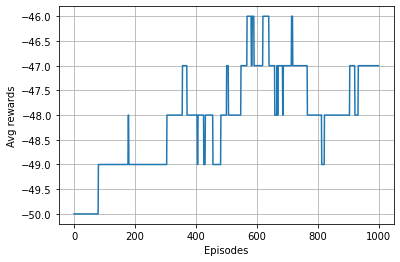

In [9]:
plt.plot(avg_hist)
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Avg rewards')

In [10]:
env = gym.make('FetchPickAndPlace-v1')

for i in range(10):
    state = env.reset()
    state, desired_goal = dic['observation'], dic['desired_goal']
    done = False
    
    while not done:
        action = agent.act(state, desired_goal, True)
        n_state, _, done, _ = env.step(action)
        n_state = n_state['observation']
        state = n_state
        env.render()
env.close()

Creating window glfw


In [11]:
agent.actor_main.save_weights('actor_weights.h5')

In [12]:
#for i in range(10):
#    state = env.reset()
#    done = False
    
#    while not done:
        #action = agent.act(state, True)
#        action = env.action_space.sample()
#        n_state = env.step(action)
#        state = n_state
#        env.render()
#env.close()

In [13]:
env.compute_reward(achieved_goal, np.array([1, 2, 3]), None)

-1.0